In [1]:
%%javascript
/**********************************************************************************************
Known Mathjax Issue with Chrome - a rounding issue adds a border to the right of mathjax markup
https://github.com/mathjax/MathJax/issues/1300
A quick hack to fix this based on stackoverflow discussions: 
http://stackoverflow.com/questions/34277967/chrome-rendering-mathjax-equations-with-a-trailing-vertical-line
**********************************************************************************************/

$('.math>span').css("border-left-color","transparent")

<IPython.core.display.Javascript object>

In [2]:
%reload_ext autoreload
%autoreload 2

# MIDS - w261 Machine Learning At Scale
__Course Lead:__ Dr James G. Shanahan (__email__ Jimi via  James.Shanahan _AT_ gmail.com)

## Assignment - HW11


---
__Name:__  Jackson Lane 
__Class:__ MIDS w261 (Summer 2016 Group 3)     
__Email:__  jelane@iSchool.Berkeley.edu     
__Week:__   11

# Table of Contents <a name="TOC"></a> 

1.  [HW Intructions](#1)   
2.  [HW References](#2)
3.  [HW Problems](#3)   
    HW11.0.  [Broadcast versus Caching in Spark ](#HW11.0)    
    HW11.1.  [HW11.2 Gradient descent](#HW11.1)   
    HW11.2.  [Gradient descent](#HW11.2)    
    HW11.3.  [Logistic Regression](#HW11.3)    
    HW11.4.  [SVMs](#HW11.4)  
    HW11.5.  [OPTIONAL  Distributed Perceptron algorithm](#HW11.5)  
    HW11.6.  [OPTIONAL  Evalution of perceptron algorihtms on PennTreeBank POS corpus](#HW11.6)  
    HW11.7.  [OPTIONAL Kernal Adatron](#HW11.7)
   
    HW11.8.  [OPTIONAL Create an animation of gradient descent for the Perceptron](#HW11.8)



<a name="1">
# 1 Instructions
[Back to Table of Contents](#TOC)

MIDS UC Berkeley, Machine Learning at Scale
DATSCIW261 ASSIGNMENT #11

Version 2016-07-27 (FINAL)


 === INSTRUCTIONS for SUBMISSIONS ===
Follow the instructions for submissions carefully.

https://docs.google.com/forms/d/1ZOr9RnIe_A06AcZDB6K1mJN4vrLeSmS2PD6Xm3eOiis/viewform?usp=send_form 


=== IMPORTANT ===

TYPE-2 Fun option: Submit HW11 using a Zeppelin notebook (See Live slides for install instructions)

TYPE-1.5 Fun option: Complete HW11.8 only (no need to complete the rest of the questions)

HW11 can be completed locally on your computer
### Documents:
* IPython Notebook, published and viewable online.
* PDF export of IPython Notebook.
    
<a name="2">
# 2 Useful References
[Back to Table of Contents](#TOC)

* Karau, Holden, Konwinski, Andy, Wendell, Patrick, & Zaharia, Matei. (2015). Learning Spark: Lightning-fast big data analysis. Sebastopol, CA: O’Reilly Publishers.
* Hastie, Trevor, Tibshirani, Robert, & Friedman, Jerome. (2009). The elements of statistical learning: Data mining, inference, and prediction (2nd ed.). Stanford, CA: Springer Science+Business Media. (Download for free [here](http://statweb.stanford.edu/~tibs/ElemStatLearn/printings/ESLII_print10.pdf))

<a name="3">
# HW Problems
[Back to Table of Contents](#TOC)

## Set up Spark Env

In [5]:
import os
import sys 

spark_home = os.environ['SPARK_HOME']
if not spark_home:
    raise ValueError('SPARK_HOME enviroment variable is not set')
sys.path.insert(0,os.path.join(spark_home,'python'))
sys.path.insert(0,os.path.join(spark_home,'python/lib/py4j-0.9-src.zip'))
from pyspark import SparkContext, SparkConf,SparkFiles

try:
    sc.stop()
except:
    pass
conf = SparkConf().setAppName("my app").setMaster("spark://master:7077")
sc = SparkContext(conf=conf)

<a name="HW11.0"></a><h2 style="color:darkblue"> HW11.0: Broadcast versus Caching in Spark </h2>
[Back to Table of Contents](#TOC)


HW11.0  

Q: __What is the difference between broadcasting and caching data in Spark? Give an example (in the context of machine learning) of each mechanism (at a highlevel). Feel free to cut and paste code examples from the lectures to support your answer.__

Both broadcasting and caching store the results of an RDD operation into memory so that it can quickly retrieved at a later point.  However, broadcasting stores data in the memory of the master node while caching stores data in the memory of the worker nodes.  This means that cached data may vary from worker to worker, but broadcasted data will always be the across the Spark cluster.  However, cached data is faster for workers to access than broadcasted data.

Q: __Review the following Spark-notebook-based implementation of KMeans and use the broadcast pattern to make this implementation more efficient. Please describe your changes in English first, implement, comment your code and highlight your changes:__

Notebook
https://www.dropbox.com/s/41q9lgyqhy8ed5g/EM-Kmeans.ipynb?dl=0

Notebook via NBViewer
http://nbviewer.ipython.org/urls/dl.dropbox.com/s/41q9lgyqhy8ed5g/EM-Kmeans.ipynb

I've copied my code from HW 10.  In the original notebook, the KMeans code stores the centroid points in a local variable called "centroids" on each worker.  This means that in a Spark Cluster, the points in the centroids variable may not be the same across different worker nodes.  In my code, the centroids variable is a broadcast variable instead of a local variable.  This ensures that all workers will have the same centroids, as they must all retrieve the centroids from the master node.

In [93]:
%matplotlib inline
import numpy as np
import pylab 
import json
size1 = size2 = size3 = 100
samples1 = np.random.multivariate_normal([4, 0], [[1, 0],[0, 1]], size1)
data = samples1
samples2 = np.random.multivariate_normal([6, 6], [[1, 0],[0, 1]], size2)
data = np.append(data,samples2, axis=0)
samples3 = np.random.multivariate_normal([0, 4], [[1, 0],[0, 1]], size3)
data = np.append(data,samples3, axis=0)
# Randomlize data
data = data[np.random.permutation(size1+size2+size3),]
np.savetxt('data.csv',data,delimiter = ',')

In [94]:
#As mentioned in the previous problem, the MLLib algorithm is probably faster 
# than the homegrown algorithm because the homegrown algorithm needs to send the
# centroids back and forth between the worker nodes, master, and client.  
#We can reduce back and forth between the worker and master nodes by by using
# broadcasts instead of closures to pass centroid information


import numpy as np
from pyspark.mllib.clustering import KMeans, KMeansModel
from numpy import array
from math import sqrt

#Rewritten to not use centroids in closure
def nearest_centroid(line,centroids):
    x = np.array([float(f) for f in line.split(',')])
    closest_centroid_idx = np.sum((x - centroids)**2, axis=1).argmin()
    return (closest_centroid_idx,(x,1))

In [92]:
errorPlot = []
K = 3
# Initialization: initialization of parameter is fixed to show an example
centroids = np.array([[0.0,0.0],[2.0,2.0],[0.0,7.0]])

D = sc.textFile("data.csv").cache()
iter_num = 0
for i in range(100):  
    #Store centroids in a broacast variable
    wBroadCast = sc.broadcast(centroids)
    #Retrieve centroids from broadcast variable
    res = D.map(lambda m: nearest_centroid(m,wBroadCast.value)).reduceByKey(lambda x,y : (x[0]+y[0],x[1]+y[1])).collect()
    #res [(0, (array([  2.66546663e+00,   3.94844436e+03]), 1001)  ), 
    #     (2, (array([ 6023.84995923,  5975.48511018]), 1000)), 
    #     (1, (array([ 3986.85984761,    15.93153464]), 999))]
    # res[1][1][1] returns 1000 here
    res = sorted(res,key = lambda x : x[0])  #sort based on clusted ID
    centroids_new = np.array([x[1][0]/x[1][1] for x in res])  

    #divide by cluster size
    #if np.sum(np.absolute(centroids_new-centroids))<0.01:
        #break
    def error(line):
        center = centroids[nearest_centroid(line,centroids)[0]]
        x,y = line.split(',')
        x = float(x)
        y = float(y)
        return sqrt((x-center[0])**2 + (y-center[1])**2)
    WSSSE = D.map(error).reduce(lambda x, y: x + y)
    errorPlot.append(WSSSE)
    iter_num = iter_num + 1     

    #if (iter_num == 1 or iter_num==10 or iter_num==20 or iter_num ==100):
        #print "Iteration" + str(iter_num)
        #print "WSSSE = %.3f" % WSSSE

        #print centroids
        #plot_iteration(centroids)
    centroids = centroids_new
print "Final Results:"
print centroids

Final Results:
[[ 4.09212992 -0.06900379]
 [ 6.07203678  5.78351158]
 [ 0.14214627  4.00781932]]


<a name="HW11.1"> <h2 style="color:darkgreen">HW11.1 Loss Functions</h2>
[Back to Table of Contents](#TOC)

 
__In the context of binary classification problems, does the linear SVM learning algorithm yield the same result as a L2 penalized logistic regesssion learning algorithm?__

__In your reponse, please discuss the loss functions, and the learnt models, and separating surfaces between the two classes.__

Not always.  One key difference is the loss function.  The linear SVM in Spark uses hinge loss while the L2 penalized logistic regression in Spark uses logistic loss.  This can mean different optimal weights for each algorithm. Also, the learnt logistic regression model in Spark will output a probability that an input set of features belong to a particular class.  However, the learnt SVM model in Spark will output a raw score with no probabilistic interpretation; rather it represents the projection of the input feature vector onto the learnt SVM separating hyperplane.  

__In the context of binary classification problems, does the linear SVM learning algorithm yield the same result as a perceptron learning algorithm?__

Not always.  Like before, the key difference is the loss function.  Linear SVM uses hinge loss while the Multilayer perceptron  learning alogrithm in Spark uses logistic loss.  Furthermore, the multilayer perceptron model also has additional hyperparameters (number of layers and number of nodes per layer).  If the learnt model is built with more than 1 layer, then one can no longer interpret the weights geometrically as a hyperplane or separating surface.

<a name="HW11.2"><h2 style="color:darkgreen">HW11.2 Gradient descent</h2>
[Back to Table of Contents](#TOC)

__In the context of logistic regression describe and define three flavors of penalized loss functions.  Are these all supported in Spark MLLib (include online references to support your answers)?__

1: Hinge Loss:

$$\max \{0, 1-y w^Tx \}, \quad y \in \{-1, +1\}$$

Where y is the actual label, x is the input features, and $w^T$ are the model weights. Hinge loss penalizes inaccurate predictions by the model's raw score $w^Tx$. The idea is that if y is not of the same sign as $w^Tx$, then $1-yw^Tx$ will be > 1 and add to the overall loss.  However, if points are correctly classified, then $1-yw^Tx$ will (usually) be negative and the function will overall output 0.  

Hinge loss is named because the graph forms a hinge when $1-yw^Tx$ becomes negative.

2: Logistic Loss:

$$\log(1+\exp( -y w^Tx)), \quad y \in \{-1, +1\}$$

It's similar to hinge loss in that it uses the raw score instead of the actual prediction, but unlike hinge loss, logistic loss use a log scale and never reaches 0.  Instead, it gets closer to 0 as the raw magnitude of the raw score increases (assuming the raw score is of the same sign as y).  

3: Zero - One Loss:

$$ \begin{cases}0 & \text{if $\hat{y} = y$}, \\ 1 & \text{otherwise}.\end{cases}$$

Zero - One loss is basically an indicator function for whether a prediction is accurate.  It outputs 1 if the prediction is inaccurate and 0 if the prediction is accurate.  Unlike the other functions, it does not take into account raw score.  


Hinge Loss and Logistic Loss are implemented in Spark, but Zero - One Loss is not.  

http://spark.apache.org/docs/latest/mllib-linear-methods.html#loss-functions

__Descibe probabilitic interpretations of the L1 and L2 priors for penalized logistic regression (HINT: see synchronous slides for week 11 for details)__

<a name="HW11.3"> <h2 style="color:darkblue"> HW11.3 Logistic Regression</h2>
[Back to Table of Contents](#TOC)

Generate 2 sets of linearly separable data with 100 data points each using the data generation code provided below and plot each in separate plots. Call one the training set and the other the testing set.

```python
def generateData(n):
 """ 
  generates a 2D linearly separable dataset with n samples. 
  The third element of the sample is the label
 """
 xb = (rand(n)*2-1)/2-0.5
 yb = (rand(n)*2-1)/2+0.5
 xr = (rand(n)*2-1)/2+0.5
 yr = (rand(n)*2-1)/2-0.5
 inputs = []
 for i in range(len(xb)):
  inputs.append([xb[i],yb[i],1])
  inputs.append([xr[i],yr[i],-1])
 return inputs

```

In [23]:
from numpy.random import rand
import numpy as np
import matplotlib.pyplot as plt
def generateData(n):
 """ 
  generates a 2D linearly separable dataset with n samples. 
  The third element of the sample is the label
 """
 xb = (rand(n)*2-1)/2-0.5
 yb = (rand(n)*2-1)/2+0.5
 xr = (rand(n)*2-1)/2+0.5
 yr = (rand(n)*2-1)/2-0.5
 inputs = []
 for i in range(len(xb)):
  inputs.append([xb[i],yb[i],1])
  inputs.append([xr[i],yr[i],-1])
 return inputs

Training Data:


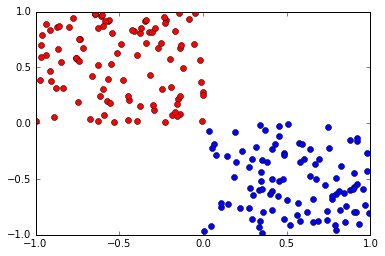

In [26]:
trainData = generateData(100)
testData = generateData(100)
cols = {-1: 'bo', 1: 'ro'}
print "Training Data:"
for point in trainData:
    plt.plot(point[0], point[1], cols[point[2]])

Test Data:


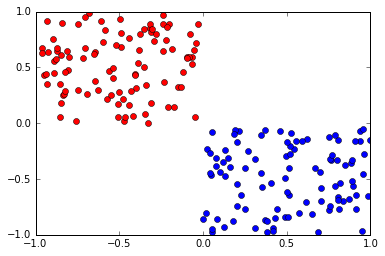

In [28]:
print "Test Data:"
for point in testData:
    plt.plot(point[0], point[1], cols[point[2]])

Modify this data generation code to generating non-linearly separable training and testing datasets (with approximately 10% of the data falling on the wrong side of the separating hyperplane. Plot the resulting datasets. 

In [105]:
from numpy.random import rand
import numpy as np
import matplotlib.pyplot as plt
def generateData(n):
 """ 
  generates a 2D dataset that is 90% linearly separable with n samples. 
  The third element of the sample is the label
 """
 xb = (rand(n)*2-1)/2-0.5
 yb = (rand(n)*2-1)/2+0.5
 xr = (rand(n)*2-1)/2+0.5
 yr = (rand(n)*2-1)/2-0.5
 inputs = []
 for i in range(len(xb)):
    #Use a random variable to misclassify 10% of variables
    c = 1
    if rand() > .1: c = -1 
    inputs.append([xb[i],yb[i],c])
    inputs.append([xr[i],yr[i],c * -1])
 return inputs



Training Data:


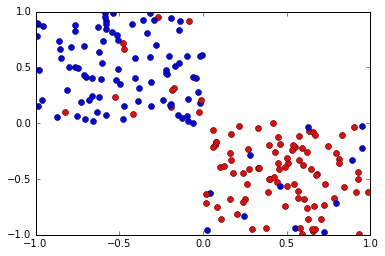

In [106]:
trainData = generateData(100)
testData = generateData(100)
cols = {-1: 'bo', 1: 'ro'}
print "Training Data:"
for point in trainData:
    plt.plot(point[0], point[1], cols[point[2]])

Test Data:


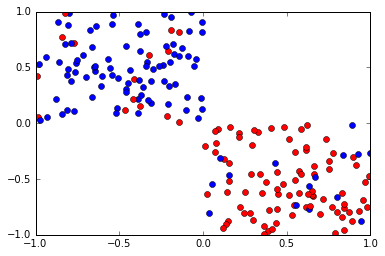

In [107]:
print "Test Data:"
for point in testData:
    plt.plot(point[0], point[1], cols[point[2]])

__NOTE: For the remainder of this problem please use the non-linearly separable training and testing datasets.__

__Using MLLib  train up a LASSO logistic regression model with the training dataset and evaluate with the testing set. What a good number of iterations for training the logistic regression model? Justify with plots and words.__

In [338]:
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.classification import LogisticRegressionWithLBFGS
from pyspark.mllib.evaluation import RegressionMetrics 

#Function to turn a point from the generateData command into a Spark LabeledPoint 
# for use in the Spark Logistic Regression algorithm
def parsePoint(point):
    c = point[-1]
    #Spark Logistic regression accepts labels of 0 and 1 instead of -1 and 1
    if point[-1] == -1:
        c = 0
    return LabeledPoint(c, point[:-1])



Iterations: 1
Weights: [0.281178224289,-0.263242711301]
Error: 0.15


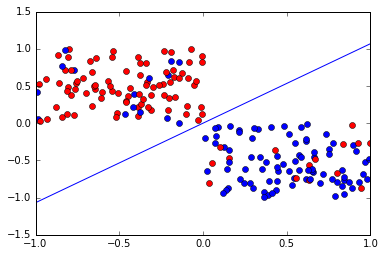

Iterations: 5
Weights: [2.10507165528,-1.67021003159]
Error: 0.15


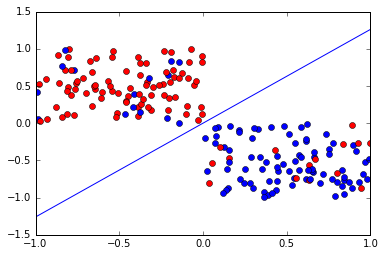

Iterations: 10
Weights: [2.26194147772,-1.51579886604]
Error: 0.15


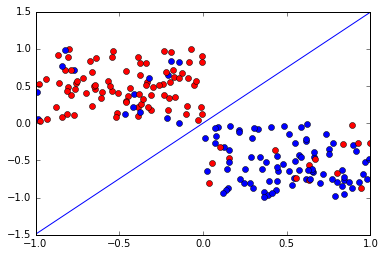

Iterations: 20
Weights: [2.26194147772,-1.51579886604]
Error: 0.15


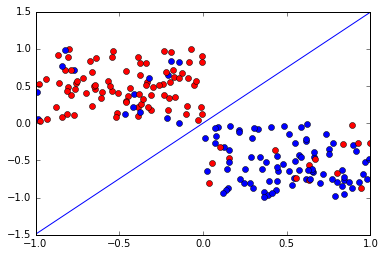

Iterations: 50
Weights: [2.26194147772,-1.51579886604]
Error: 0.15


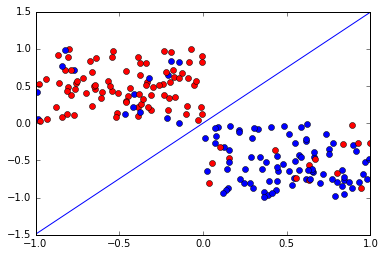

Iterations: 100
Weights: [2.26194147772,-1.51579886604]
Error: 0.15


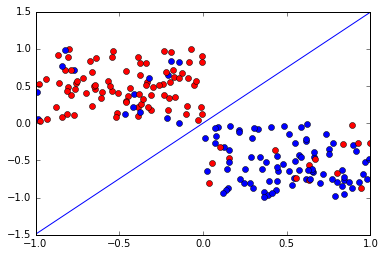

In [118]:
# driver function
def LogisticMLLibDriver():
    # I will test with the following numbers of iterations
    iterations = [1,5,10,20,50,100]
    
    trainData_RDD = sc.parallelize(trainData).map(parsePoint)
    testData_RDD = sc.parallelize(testData).map(parsePoint)

    for i in iterations:
        #Build the model
        model = LogisticRegressionWithLBFGS.train(trainData_RDD, intercept=False,iterations=i, regType='l1',regParam =.01)
        
        #Run the model on test data and store results as (predicted, actual) tuples)
        pairs = testData_RDD.map(lambda p: (float(model.predict(p.features)),p.label)).collect()
        scoreAndLabels  = sc.parallelize(pairs)
        
        #Plug pairs data into Spark RegressionMetrics algorithm
        metrics = RegressionMetrics (scoreAndLabels)
        print "Iterations:", i
        print "Weights:", model.weights        
        # Print mean absolute error or l1-norm loss
        print "Error:",metrics.meanAbsoluteError
        
        #Plot test data
        for point in testData:
            color = "bo"
            if (point[2] == -1):
                color = "ro"
            plt.plot(point[0], point[1], color)
            
        #Plot the line given model weights
        coords = [-1, 1]
        y1 = (model.weights[0])/model.weights[1]
        y2 = (-1*model.weights[0])/model.weights[1]
        plt.plot([-1, 1],[y1,y2])
        plt.show()
        
LogisticMLLibDriver()

I think we could stop after just 1 iteration.  There was no improvement over the misclassification error rate of .15.  This may be due to the small sample sizes

While model weights themselves seem converge after 10 iterations, there's no improvement in the misclassification error rate.  So there's not really a reason to wait for the model to converge.

__Derive and implement in Spark a weighted  LASSO logistic regression. Implement a convergence test of your choice to check for termination within your training algorithm.__

__Weight the above training dataset as follows:  Weight each example using the inverse vector length (Euclidean norm):__ 

>weight(X)= 1/||X||, 

>where ||X|| = SQRT(X.X)= SQRT(X1^2 + X2^2)

>Here X is vector made up of X1 and X2.

__Evaluate your homegrown weighted  LASSO logistic regression on the test dataset. Report misclassification error (1 - Accuracy) and how many iterations does it took to converge.__

In [314]:
from numpy.random import rand
import numpy as np
import matplotlib.pyplot as plt

# Turn test data points into weighted, labeled points.
def parsePoint(point):
    # calculate weight based on Euclidean norm
    EuclideanNorm = (point[0] ** 2 + point[1] ** 2) ** .5
    weight = 1/EuclideanNorm
    
    #I had trouble extending the LabeledPoints class, so instead I created a dictionary representation
    return {'features':point[:-1],'weight':weight,'label':point[-1]}

#Function to calculate gradient of logistic loss function
#http://spark.apache.org/docs/latest/mllib-linear-methods.html#loss-functions
def LogisticLossGradient(point,w):

    expTerm = 1 + np.exp(-point['label']*np.dot( point["features"],w))
    loss = 1-1 /expTerm
    return loss

def LogisticHomeGrown(data):
    #Set hyperparameters
    n = data.count()
    stepSize = .01
    regParam = .01
    tolerance = 1 * 10 ** -3
    weights = np.random.normal(size=2)
    i=0
    while(True):
        i += 1
        wBroadcast = sc.broadcast(weights)
        gradients = data.map(lambda point: point["weight"] * \
                            LogisticLossGradient(point,wBroadcast.value)
                            * -point['label'] * np.array(point['features']))
        totalGradient = gradients.reduce(lambda a,b: a + b)
        #Calculate delta value to check for convergence
        delta =  stepSize * (totalGradient + regParam * weights) / n
        if sum(abs(delta))/sum(abs(weights))<=tolerance *sum(abs(weights)):  
            return (weights,i)
            break
        weights = weights - delta

In [315]:
# driver function
def LogisticHomeGrownDriver():    
    # set up RDDs for training and test data
    trainData_RDD = sc.parallelize(trainData).map(parsePoint)
    testData_RDD = sc.parallelize(testData).map(parsePoint)
    weights,iterations = LogisticHomeGrown(trainData_RDD)
    wBroadcast = sc.broadcast(weights)
    #Calculate total error
    error = testData_RDD.map(lambda point: point['label']*np.dot(point['features'], wBroadcast.value))

    #Get inaccurate points
    misclassificationCount = error.filter(lambda s: s < 0).count()
    
    #Print Summary Statistics
    print "Iterations:",iterations
    print "Weights:", weights
    print "Misclassification error:", float(misclassificationCount)/testData_RDD.count()

    #Plot test data
    for point in testData:
        color = "bo"
        if (point[2] == -1):
            color = "ro"
        plt.plot(point[0], point[1], color)
        
    #Plot the line given model weights
    y1 = (weights[0])/weights[1]
    y2 = (-1*weights[0])/weights[1]
    plt.plot([-1, 1],[y1,y2])
    plt.show()

Iterations: 764
Weights: [ 1.09094784 -0.53148281]
Misclassification error: 0.15


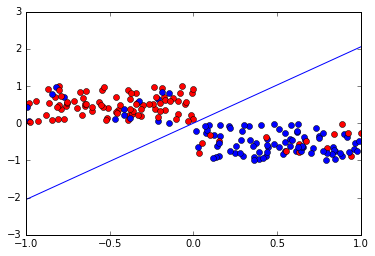

In [316]:
LogisticHomeGrownDriver()

__Does Spark MLLib have a weighted LASSO logistic regression implementation. If so use it and report your findings on the weighted training set and test set.__

No. Spark does not have any built in weighted logistic regression functionalities.

<a name="HW10.4"><h2 style="color:darkblue"> HW11.4 SVMs  </h2>
[Back to Table of Contents](#TOC)

Use the non-linearly separable training and testing datasets from HW11.3 in this problem.

Using MLLib  train up a soft SVM model with the training dataset and evaluate with the testing set. What is a good number of iterations for training the SVM model? Justify with plots and words. 

In [318]:
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.classification import SVMWithSGD
from pyspark.mllib.evaluation import RegressionMetrics 

#Function to turn a point from the generateData command into a Spark LabeledPoint 
# for use in the Spark Logistic Regression algorithm
def parsePoint(point):
    c = point[-1]
    if point[-1] == -1:
        c = 0
    return LabeledPoint(c, point[:-1])

Iterations: 1
Weights: [0.373162072005,-0.365214097552]
Error: 0.15


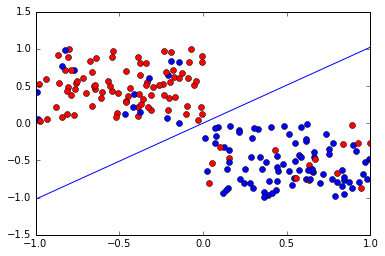

Iterations: 5
Weights: [0.9721134439,-0.932311834616]
Error: 0.15


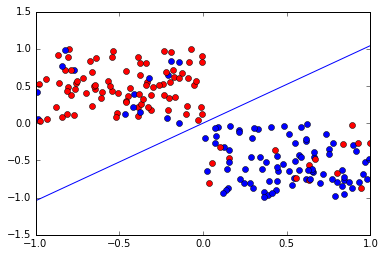

Iterations: 10
Weights: [1.14803913834,-1.07712683489]
Error: 0.15


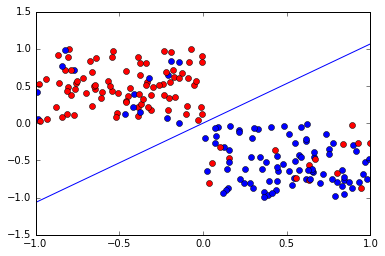

Iterations: 20
Weights: [1.26019678772,-1.16712351413]
Error: 0.15


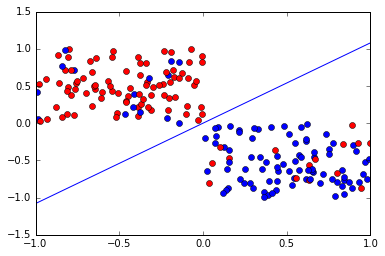

Iterations: 50
Weights: [1.35601420909,-1.23686818024]
Error: 0.15


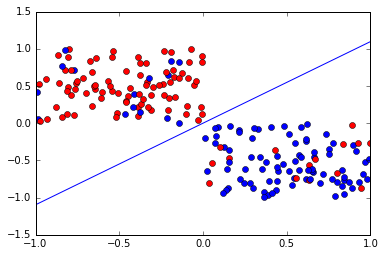

Iterations: 100
Weights: [1.35601420909,-1.23686818024]
Error: 0.15


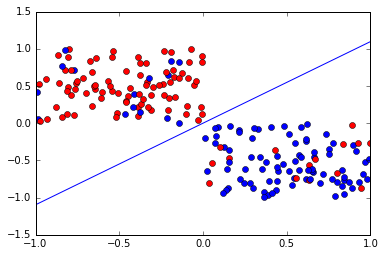

In [319]:
# driver function
def SVMMLibDriver():
    
    # I will test with the following numbers of iterations
    iterations = [1,5,10,20,50,100]
    
    trainData_RDD = sc.parallelize(trainData).map(parsePoint)
    testData_RDD = sc.parallelize(testData).map(parsePoint)

    for i in iterations:
        #Build the model
        model = SVMWithSGD.train(trainData_RDD, intercept=False,iterations=i)
        
        #Run the model on test data and store results as (predicted, actual) tuples)
        pairs = testData_RDD.map(lambda p: (float(model.predict(p.features)),p.label)).collect()
        scoreAndLabels  = sc.parallelize(pairs)
        
        #Plug pairs data into Spark RegressionMetrics algorithm
        metrics = RegressionMetrics (scoreAndLabels)
        print "Iterations:", i
        print "Weights:", model.weights        
        # Print mean absolute error or l1-norm loss
        print "Error:",metrics.meanAbsoluteError
        
        #Plot test data
        for point in testData:
            color = "bo"
            if (point[2] == -1):
                color = "ro"
            plt.plot(point[0], point[1], color)
            
        #Plot the line given model weights
        coords = [-1, 1]
        y1 = (model.weights[0])/model.weights[1]
        y2 = (-1*model.weights[0])/model.weights[1]
        plt.plot([-1, 1],[y1,y2])
        plt.show()
        
SVMMLibDriver()

Again, I think we can stop after just 1 iteration.  There was no improvement over the misclassification error rate of .15.  This may be due to the small sample sizes

__Derive and Implement in Spark a weighted soft linear svm classification learning algorithm.
Evaluate your homegrown weighted soft linear svm classification learning algorithm on the weighted training dataset and test dataset from HW11.3. Report misclassification error (1 - Accuracy) and how many iterations does it took to converge?  How many support vectors do you end up?__

In [335]:
from numpy.random import rand
import numpy as np
import matplotlib.pyplot as plt

# Turn test data points into weighted, labeled points.
def parsePoint(point):
    # calculate weight based on Euclidean norm
    EuclideanNorm = (point[0] ** 2 + point[1] ** 2) ** .5
    weight = 1/EuclideanNorm
    
    #I had trouble extending the LabeledPoints class, so instead I created a dictionary representation
    return {'features':point[:-1],'weight':weight,'label':point[-1]}

#Function to calculate gradient of hinge loss function
#http://spark.apache.org/docs/latest/mllib-linear-methods.html#loss-functions
def SVMGradient(point):
    return -point['label']*np.array(point['features'])

#Function to check whether a particular point is close enough to the weights vector
# to be considered a support vector
def SVMMargin(point,weights,margin):
    distance = point['label']*np.dot(weights,point['features'])
    return distance < margin

def SVMHomeGrown(data):
    #Set hyperparameters
    n = data.count()
    stepSize = .01
    regParam = .01
    tolerance = 1 * 10 ** -3
    margin = 1
    weights = np.random.normal(size=2)
    i=0
    while(True):
        i += 1
        wBroadcast = sc.broadcast(weights)
        
        #Get only the support vectors
        supportVectors = data.filter(lambda point: SVMMargin(point,wBroadcast.value,margin)) 
        
        #Calculate gradient
        gradients = supportVectors.map(lambda point: point["weight"] *SVMGradient(point))
        totalGradient = gradients.reduce(lambda a,b: a + b)
        #Calculate delta value to check for convergence
        delta =  stepSize * (totalGradient + regParam * weights) / n
        if sum(abs(delta))<=tolerance *sum(abs(weights)):  
            return (weights,i)
            break
        weights = weights - delta

In [336]:
# driver function
def SVMHomeGrownDriver():    
    # set up RDDs for training and test data
    trainData_RDD = sc.parallelize(trainData).map(parsePoint)
    testData_RDD = sc.parallelize(testData).map(parsePoint)
    weights,iterations = SVMHomeGrown(trainData_RDD)
    wBroadcast = sc.broadcast(weights)
    #Calculate total error
    error = testData_RDD.map(lambda point: point['label']*np.dot(point['features'], wBroadcast.value))

    #Get inaccurate points
    misclassificationCount = error.filter(lambda s: s < 0).count()
    
    #Print Summary Statistics
    print "Iterations:",iterations
    print "Weights:", weights
    print "Misclassification error:", float(misclassificationCount)/testData_RDD.count()

    #Plot test data
    for point in testData:
        color = "bo"
        if (point[2] == -1):
            color = "ro"
        plt.plot(point[0], point[1], color)
        
    #Plot the line given model weights
    y1 = (weights[0])/weights[1]
    y2 = (-1*weights[0])/weights[1]
    plt.plot([-1, 1],[y1,y2])
    plt.show()

Iterations: 312
Weights: [ 0.9538673  -1.63764449]
Misclassification error: 0.15


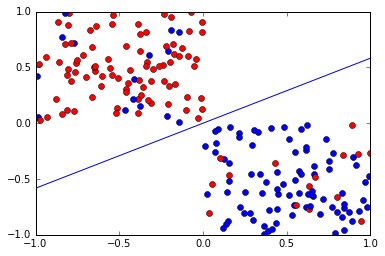

In [337]:
SVMHomeGrownDriver()

__Does Spark MLLib have a weighted soft SVM learner. If so use it and report your findings on the weighted training set and test set.__  

No. Spark does not have any built in weighted SVM functionalities.

<a name="HW11.5"><h2 style="color:darkgreen"> HW11.5  [OPTIONAL] Distributed Perceptron algorithm. </h2>
[Back to Table of Contents](#TOC)

Using the following papers as background:
http://static.googleusercontent.com/external_content/untrusted_dlcp/research.google.com/en//pubs/archive/36266.pdf

https://www.dropbox.com/s/a5pdcp0r8ptudgj/gesmundo-tomeh-eacl-2012.pdf?dl=0

http://www.slideshare.net/matsubaray/distributed-perceptron 

Implement each of the following flavors of perceptron learning algorithm:

1. Serial (All Data): This is the classifier returned if trained serially on all the available data.  On a single computer for example (Mistake driven)
2. Serial (Sub Sampling): Shard the data, select one shard randomly and train serially. 
3. Parallel (Parameter Mix): Learn a perceptron locally on each shard: 
Once learning is complete combine each learnt percepton using a uniform weighting
4. Parallel (Iterative Parameter Mix) as described in the above papers.

In [71]:
## Code goes here

In [72]:
## Drivers & Runners

In [73]:
## Run Scripts, S3 Sync

<a name="HW11.6"><h2 style="color:darkblue"> HW11.6 [OPTIONAL: consider doing this in a group]  Evalution of perceptron algorihtms on PennTreeBank POS corpus </h2>
[Back to Table of Contents](#TOC)

Reproduce the experiments reported in the following paper:

*Prediction with MapReduce - Andrea Gesmundo and  Nadi Tomeh*

http://www.aclweb.org/anthology/E12-2020 

These experiments focus on the prediction accuracy on a part-of-speech
(POS) task using the PennTreeBank corpus. They use sections 0-18 of the Wall
Street Journal for training, and sections 22-24 for testing.
 


<a name="HW11.7"><h2 style="color:darkgreen"> HW11.7 [OPTIONAL: consider doing this in a group] Kernal Adatron  </h2>
[Back to Table of Contents](#TOC)

Implement the Kernal Adatron in Spark (contact Jimi for details)


<a name="HW11.8"><h2 style="color:darkgreen"> HW11.8 [OPTIONAL] Create an animation of gradient descent for the Perceptron learning or for the logistic regression </h2>
[Back to Table of Contents](#TOC)
    
Learning with the following 3 training examples. Present the progress in terms of the 2 dimensional input space in terms of a contour plot and also in terms of the 3D surface plot. See Live slides for an example.
[Back to Table of Contents](#TOC)
Here is a sample training dataset that can be used:
-2, 3, +1
-1, -1, -1
2, -3, 1

Please feel free to use 
 + R (yes R!)
 + d3
 + https://plot.ly/python/
 + Matplotlib

I am happy for folks to collaborate on HW11.8 also.

It would be great to get the 3D surface and contours lines (with solution region and label normalized data) all in the same graph




In [77]:
## Code goes here

In [78]:
## Drivers & Runners

In [79]:
## Run Scripts, S3 Sync

[Back to Table of Contents](#TOC)
<center><div class='jumbotron'><h2 style='color:green'>-------  END OF HOWEWORK --------</h2></div></center>